#Problem Tanımı: Omurga Disk Kayması Tespiti

Omurga disk kayması, omurgadaki disklerin yer değiştirmesi sonucu omurilik veya sinirlere baskı yaparak ağrı ve fonksiyon kaybına yol açan bir durumdur. Günümüzde, manyetik rezonans görüntüleme (MRI) gibi ileri görüntüleme teknikleri kullanılarak disk kayması tespiti yapılmaktadır. Ancak, bu tür görüntülerin incelenmesi oldukça zaman alıcıdır ve hata payı insan faktörüne bağlı olarak değişebilmektedir. Bu projede, MRI görüntüleri üzerinde otomatik segmentasyon teknikleri kullanılarak omurga disk kayması ve hasar tespiti yapmayı hedefliyoruz.

Bu projenin amacı, disk kaymasının hızlı ve doğru bir şekilde tespitini sağlayacak bir otomasyon sistemi geliştirmektir. Bu sistem, omurga bölgesindeki kaymış diskleri segmentasyon yoluyla işaretleyecek ve ardından potansiyel hastalıklı alanları tanımlayacaktır.



#1. Gauss Pyramid (Gauss Piramidi) Oluşturulması:

Gauss Pyramid görüntü işleme tekniklerinden biridir. Görüntü üzerinde farklı çözünürlük seviyeleri oluşturulup, her seviyede detay kaybı yaşanır. Bu piramit, farklı çözünürlüklerdeki (yani farklı boyutlardaki) görüntülerin bir araya getirilmesidir.
gauss_pyramid() fonksiyonu, verilen bir gri tonlamalı görüntü üzerinde piramit seviyeleri oluşturur. Her bir seviyede çözünürlük azalarak görüntü boyutları küçülür.
Parametreler:
image: Giriş görüntüsü (gri tonlamalı).
max_levels: Maksimum seviye sayısı, piramitin kaç seviyede oluşturulacağına karar verir.

#2. Kenar Tespiti ve Çizgiler Çıkartma:
canny() fonksiyonu ile her bir piramit seviyesindeki görüntü üzerinde kenar tespiti yapılır. Bu, görüntüdeki önemli yapıları (kenarları) ortaya çıkarmak için kullanılan bir algoritmadır.
Tespit edilen kenarlardan çizgiler çıkarılır (extract_lines() fonksiyonu). Bu işlemde, kenarların bulunduğu her pikselden başlayarak, farklı yönlerde çizgiler çıkarılmaya çalışılır. Çizgi uzunluğu (line_length) parametre olarak belirlenmiştir.

#3. Patch (Yama) Çıkartma:
extract_patches() fonksiyonu ile her bir kenarın çevresindeki patch_size boyutlarında yamalar (küçük kareler) çıkarılır. Bu işlem, görüntüdeki her kenar çevresindeki belirli bölgeleri analiz etmek için yapılır.
Bu yamalar, her kenarın çevresindeki özellikleri daha ayrıntılı incelemek amacıyla kullanılır. Çıkarılan yamaların her birinin ortalaması alınır.

#4. Kenarların Genişletilmesi:
dilate_and_code() fonksiyonu ile tespit edilen kenarların etrafında büyütme (dilatasyon) işlemi yapılır. Bu işlem, kenarların etrafındaki bölgedeki bilgileri daha geniş bir alanda toplayarak, kenarın etkisini artırmak için yapılır.
Bu genişletilen bölgedeki piksellerin ortalaması alınarak bir değer elde edilir.

#5. Sonuçların Toplanması ve Görselleştirilmesi:
Her piramit seviyesi için yukarıdaki işlemler gerçekleştirilir ve sonuçlar bir listeye kaydedilir.
İşlem sonunda, her seviye için:
Çizgilerin sayısı.
Yamaların sayısı.
Genişletilmiş bölge ortalaması.
Ayrıca her seviye için, orijinal görüntü ve kenarların tespit edildiği görüntü de görselleştirilir.

#6. Sonuçların Yazdırılması:
Kodun sonunda, her piramit seviyesinin işlem sonuçları yazdırılır. Bu, her seviyedeki çizgiler, yamalar ve genişletilmiş bölge ortalamaları hakkında bilgi verir.
Bu işlem genel olarak, görüntüdeki kenarları tespit etmek, bu kenarları farklı çözünürlük seviyelerinde analiz etmek ve daha detaylı özellikler çıkartmak amacıyla yapılır. Gauss Piramidi'nin kullanılması, görüntünün farklı çözünürlük seviyelerindeki özelliklerin daha iyi incelenmesini sağlar.

Seviye 1 işleniyor...


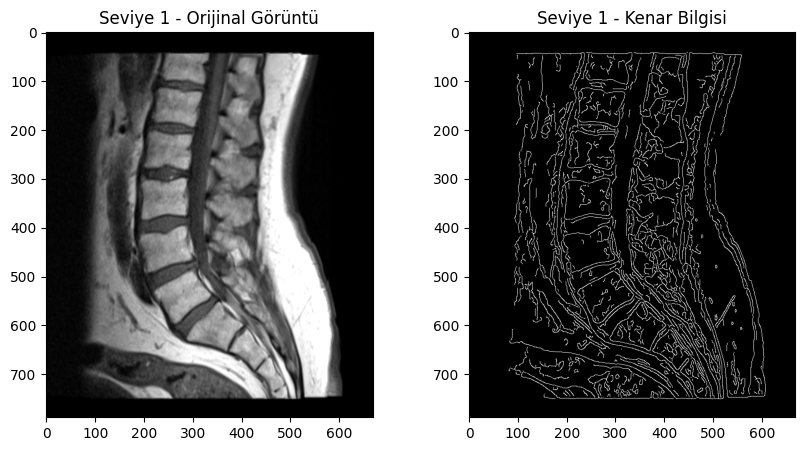

Seviye 2 işleniyor...


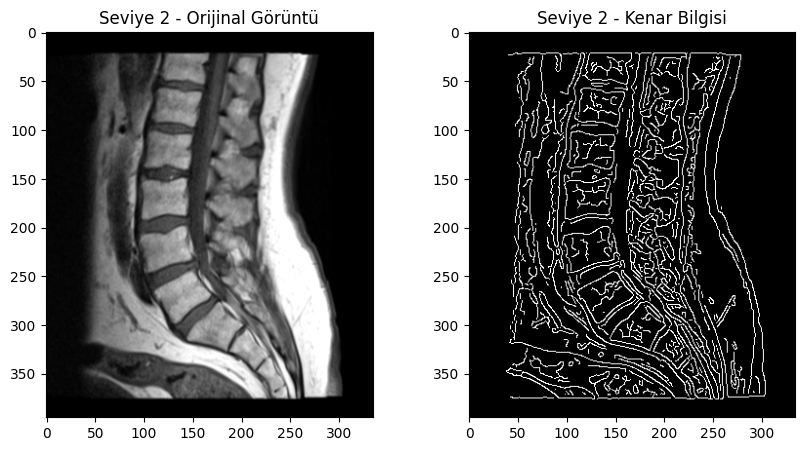

Seviye 3 işleniyor...


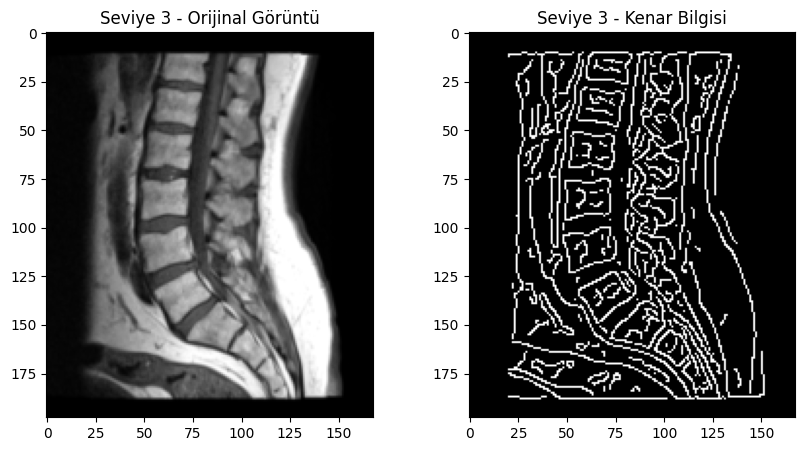

Seviye 4 işleniyor...


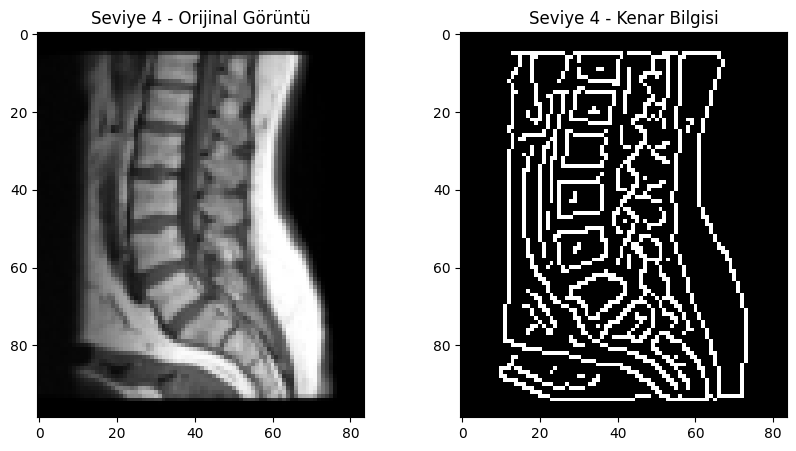

Seviye 1:
- Çizgi Sayısı: 241240
- Patch Sayısı: 30155
- Genişletilmiş Bölge Ortalaması: 0.43142044224963366
Seviye 2:
- Çizgi Sayısı: 102312
- Patch Sayısı: 12789
- Genişletilmiş Bölge Ortalaması: 0.42023358656852994
Seviye 3:
- Çizgi Sayısı: 33480
- Patch Sayısı: 4185
- Genişletilmiş Bölge Ortalaması: 0.3957081896744591
Seviye 4:
- Çizgi Sayısı: 10712
- Patch Sayısı: 1339
- Genişletilmiş Bölge Ortalaması: 0.37063394232867586


In [2]:
from skimage.transform import pyramid_gaussian
from skimage.morphology import binary_dilation, disk
from skimage.measure import label, regionprops
from skimage.feature import canny
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

def gauss_pyramid(image, max_levels):
    """
    Gauss Pyramid seviyelerini oluştur.
    :param image: Giriş görüntüsü (gri seviyeli)
    :param max_levels: Maksimum seviye sayısı
    :return: Gauss Pyramid seviyeleri listesi
    """
    return list(pyramid_gaussian(image, max_layer=max_levels, downscale=2))

def process_gauss_pyramid(pyramid, line_length, patch_size, struct_element_radius):
    """
    Gauss Pyramid seviyeleri için kenar işlemlerini uygula.
    :param pyramid: Gauss Pyramid seviyeleri
    :param line_length: Çizgi uzunluğu (X)
    :param patch_size: Patch boyutu (m x m)
    :param struct_element_radius: Genişletme için yapısal elementin yarıçapı
    :return: Her seviye için işlenen kenar bilgisi listesi
    """
    results = []

    for level, img in enumerate(pyramid):
        print(f"Seviye {level + 1} işleniyor...")

        # Kenar tespiti (bwboundary mantığı)
        edges = canny(img, sigma=1)
        boundaries = np.column_stack(np.where(edges))

        # 1) Çizgiler çıkar ve kodla
        def extract_lines(boundaries, image, line_length):
            rows, cols = image.shape
            lines = []

            for y, x in boundaries:
                directions = [
                    (0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)
                ]

                for dy, dx in directions:
                    line = []
                    for i in range(line_length):
                        new_y, new_x = y + i * dy, x + i * dx
                        if 0 <= new_y < rows and 0 <= new_x < cols:
                            line.append(image[new_y, new_x])
                        else:
                            break
                    if len(line) == line_length:
                        lines.append(line)

            return np.array(lines)

        lines = extract_lines(boundaries, img, line_length)

        # 2) mxm boyutlu yamalar al ve kodla
        def extract_patches(boundaries, image, patch_size):
            rows, cols = image.shape
            half_size = patch_size // 2
            patches = []

            for y, x in boundaries:
                y_min = max(y - half_size, 0)
                y_max = min(y + half_size + 1, rows)
                x_min = max(x - half_size, 0)
                x_max = min(x + half_size + 1, cols)
                patch = image[y_min:y_max, x_min:x_max]

                if patch.shape == (patch_size, patch_size):
                    patches.append(np.mean(patch))

            return np.array(patches)

        patches = extract_patches(boundaries, img, patch_size)

        # 3) Kenarları genişlet ve kodla
        def dilate_and_code(boundaries, image, struct_element_radius):
            rows, cols = image.shape
            edge_mask = np.zeros_like(image, dtype=bool)

            for y, x in boundaries:
                edge_mask[y, x] = True

            struct_element = disk(struct_element_radius)
            dilated_edges = binary_dilation(edge_mask, struct_element)
            dilated_region_pixels = image[dilated_edges]

            return np.mean(dilated_region_pixels)

        region_mean = dilate_and_code(boundaries, img, struct_element_radius)

        # Sonuçları kaydet
        results.append({
            "level": level + 1,
            "lines": lines,
            "patches": patches,
            "region_mean": region_mean
        })

        # Görselleştirme: Orijinal Gauss Pyramid görüntüsü ve kenarlar
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Seviye {level + 1} - Orijinal Görüntü")

        plt.subplot(1, 2, 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f"Seviye {level + 1} - Kenar Bilgisi")
        plt.show()

    return results


# Test görüntüsünü yükle
test_image_path = '/content/drive/MyDrive/DB2/img (5).png'
test_image = io.imread(test_image_path)

# Eğer görüntü 4 kanal içeriyorsa, alfa kanalını atın ve sadece RGB kullanın
if test_image.shape[2] == 4:
    test_image = test_image[:, :, :3]

# Test görüntüsü gri seviyeye dönüştürülmüş mü kontrol edin
test_image = color.rgb2gray(test_image)

# Gauss Pyramid oluştur
max_levels = 3  # Örneğin, 4 seviye
pyramid = gauss_pyramid(test_image, max_levels)

# Kenar işlemleri için parametreler
line_length = 5
patch_size = 5
struct_element_radius = 5


# Gauss Pyramid seviyelerinde kenar işlemleri
pyramid_results = process_gauss_pyramid(pyramid, line_length, patch_size, struct_element_radius)

# Her seviyenin sonuçlarını yazdır
for result in pyramid_results:
    print(f"Seviye {result['level']}:")
    print(f"- Çizgi Sayısı: {len(result['lines'])}")
    print(f"- Patch Sayısı: {len(result['patches'])}")
    print(f"- Genişletilmiş Bölge Ortalaması: {result['region_mean']}")
